# Handwritten Digit Generator

## Imports

In [1]:
# PyTorch and related imports
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Utility imports
from pathlib import Path
from mpl_toolkits.axes_grid1 import inset_locator
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

## Hyperparameters

In [2]:
NUM_EPOCHS = 100          # Number of epochs to train the model
LATENT_DIM = 20           # Dimension of the latent space
BATCH_SIZE = 32           # Size of each batch of data
NUM_WORKERS = 0           # Number of subprocesses to use for data loading

# Learning rate scheduler parameters
lr_slowing_patience = 5   # Patience for reducing learning rate
lr_stopping_patience = 10 # Patience for stopping training

## Device configuration

In [3]:
# Configuring device to use GPU if available, otherwise CPU
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:1" if cuda_available else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


## Paths

In [4]:
# Setting up paths for saving the model
BASE_DIR = Path.cwd()             # Current working directory
MODEL_DIR = BASE_DIR / "model"    # Directory to save the model
MODEL_DIR.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

# Model file name and path
MODEL_NAME = "VAE.pth"
MODEL_PATH = MODEL_DIR / MODEL_NAME

### Helper Functions

In [5]:
def sample_digit(latent_mappings, digit, num_samples=1, latent_dim=None):
    """
    Sample digit images from the latent space.
    
    Parameters:
    - latent_mappings (dict): A dictionary mapping digits to their latent space vectors.
    - digit (int): The digit to sample from.
    - num_samples (int): Number of samples to generate.
    - latent_dim (int, optional): Dimension of the latent space.

    Returns:
    - samples (ndarray): Generated samples from the latent space.
    """
    latent_vectors = latent_mappings[digit]
    mean = np.mean(latent_vectors, axis=0)
    covariance = np.cov(latent_vectors.T)
    samples = np.random.multivariate_normal(mean, covariance, num_samples)
    return samples

In [6]:
def show_images(images, num_rows=1, num_cols=5, title=None):
    """
    Display a grid of images.
    
    Parameters:
    - images (list or ndarray): List or array of images to display.
    - num_rows (int): Number of rows in the display grid.
    - num_cols (int): Number of columns in the display grid.
    - title (str, optional): Title of the figure.

    Returns:
    - None
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
    if title is not None:
        fig.suptitle(title)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        if img.shape[0] == 784:
            img = img.reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
def show_images_with_info(image_data, num_images=10, title=None):
    """
    Display images with additional info like labels, clusters, and loss.
    
    Parameters:
    - image_data (list of dicts): List containing dictionaries with image data and info.
    - num_images (int): Number of images to display.
    - title (str, optional): Title of the figure.

    Returns:
    - None
    """
    fig, axes = plt.subplots(2, num_images, figsize=(1.5 * num_images, 4))
    if title is not None:
        fig.suptitle(title)
    for i in range(num_images):
        img_data = image_data[i]
        ax = axes[0, i]
        ax.imshow(img_data['original'].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {img_data['label']}\nCluster: {img_data['nearest_cluster']}\nLoss: {img_data['loss']:.4f}")
        ax.axis('off')
        ax = axes[1, i]
        ax.imshow(img_data['reconstructed'].reshape(28, 28), cmap='gray')
        ax.set_title("Reconstructed")
        ax.axis('off')
    plt.subplots_adjust(hspace=1.0)  # Increase the value to create more space
    plt.tight_layout()
    plt.show()

In [8]:
def reconstruct_images_and_loss(model, data):
    """
    Reconstruct images and calculate the reconstruction loss.
    
    Parameters:
    - model (nn.Module): The VAE model.
    - data (Tensor): Input data to the model.

    Returns:
    - original_data (Tensor): Original input data.
    - reconstructed_data (Tensor): Reconstructed data from the model.
    - reconstruction_loss (Tensor): Loss calculated between original and reconstructed data.
    """
    data_flattened = data.view(data.size(0), -1)
    reconstructed_data, _, _ = model(data)
    reconstructed_data_flattened = reconstructed_data.view(reconstructed_data.size(0), -1)
    reconstruction_loss = F.mse_loss(reconstructed_data_flattened, data_flattened, reduction='none').mean(dim=1)
    return data, reconstructed_data, reconstruction_loss

In [9]:
def find_nearest_cluster(outlier, actual_label, centroids):
    """
    Find the nearest cluster for a given outlier.
    
    Parameters:
    - outlier (ndarray): The outlier data point.
    - actual_label (int): The actual label of the outlier.
    - centroids (dict): Dictionary of cluster centroids.

    Returns:
    - nearest_cluster (int): The label of the nearest cluster.
    """
    min_distance = np.inf
    nearest_cluster = None
    for label, centroid in centroids.items():
        if label != actual_label:
            distance = np.linalg.norm(outlier - centroid)
            if distance < min_distance:
                min_distance = distance
                nearest_cluster = label
    return nearest_cluster

In [10]:
def process_image_through_vae(image, model, transform, device):
    """
    Process an image through the VAE model.
    
    Parameters:
    - image (PIL.Image or ndarray): The input image to process.
    - model (nn.Module): The VAE model.
    - transform (callable): Transformations to apply to the image.
    - device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    - reconstructed_image_np (ndarray): The reconstructed image in numpy format.
    """
    image_tensor = transform(image).to(device)
    with torch.no_grad():
        reconstructed_image, _, _ = model(image_tensor)
    reconstructed_image_np = reconstructed_image.cpu().view(28, 28).numpy()
    return reconstructed_image_np

### Data Import

#### MNIST Data

In [11]:
# Define a transform to convert PIL images to tensors
transform = transforms.Compose([transforms.ToTensor()])

In [12]:
# Download and prepare the MNIST training dataset
train_data = datasets.MNIST(
    root="data",            # Directory to store the dataset
    train=True,             # Load training data
    download=True,          # Download the data if not already downloaded
    transform=transform,    # Apply the defined transformation
    target_transform=None   # No transformation on the target
)

# Download and prepare the MNIST testing dataset
test_data = datasets.MNIST(
    root="data",            # Directory to store the dataset
    train=False,            # Load testing data
    download=True,          # Download the data if not already downloaded
    transform=transform,    # Apply the defined transformation
    target_transform=None   # No transformation on the target
)

In [13]:
# Create a DataLoader for the training dataset
train_dataloader = DataLoader(
    dataset=train_data,     # Training dataset
    batch_size=BATCH_SIZE,  # Batch size
    shuffle=True,           # Shuffle the data
    num_workers=NUM_WORKERS # Number of worker processes for data loading
)

# Create a DataLoader for the testing dataset
test_dataloader = DataLoader(
    dataset=test_data,      # Testing dataset
    batch_size=BATCH_SIZE,  # Batch size
    shuffle=False,          # Do not shuffle the data
    num_workers=NUM_WORKERS # Number of worker processes for data loading
)

## Model

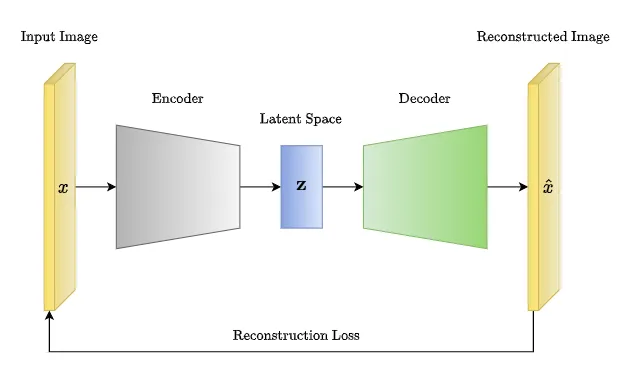

### Model Architecture

In [14]:
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()
        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dim)
        
        # Decoder layers
        self.fc_decoder = nn.Linear(LATENT_DIM, 128 * 3 * 3)
        self.decoder_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.decoder_conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        """
        Encodes the input image to latent space.
        
        Parameters:
        - x (Tensor): Input image batch.
        
        Returns:
        - mu (Tensor): Mean of the latent space.
        - logvar (Tensor): Log variance of the latent space.
        """
        h1 = F.relu(self.encoder_conv1(x))
        h2 = F.relu(self.encoder_conv2(h1))
        h3 = F.relu(self.encoder_conv3(h2))
        h3 = h3.view(-1, 128 * 3 * 3)
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        
        Parameters:
        - mu (Tensor): Mean of the latent space.
        - logvar (Tensor): Log variance of the latent space.
        
        Returns:
        - z (Tensor): Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """
        Decodes the latent vector back to image space.
        
        Parameters:
        - z (Tensor): Latent vector.
        
        Returns:
        - Tensor: Reconstructed image batch.
        """
        h3 = F.relu(self.fc_decoder(z))
        h3 = h3.view(-1, 128, 3, 3)
        h4 = F.relu(self.decoder_conv1(h3))
        h5 = F.relu(self.decoder_conv2(h4))
        return torch.sigmoid(self.decoder_conv3(h5))

    def forward(self, x):
        """
        Forward pass through the network.
        
        Parameters:
        - x (Tensor): Input image batch.
        
        Returns:
        - Tensor: Reconstructed image batch.
        - mu (Tensor): Mean of the latent space.
        - logvar (Tensor): Log variance of the latent space.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Training and Testing Functions

#### VAE Loss Function

In [15]:
def vae_loss(recon_x, x, mu, logvar):
    """
    VAE loss function combining reconstruction loss and KL divergence.
    
    Parameters:
    - recon_x (Tensor): Reconstructed data.
    - x (Tensor): Original input data.
    - mu (Tensor): Mean of the latent space.
    - logvar (Tensor): Log variance of the latent space.
    
    Returns:
    - loss (Tensor): Total loss combining reconstruction and KL divergence.
    """
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#### Training Step

In [16]:
def train_step(model, train_dataloader, optimizer):
    """
    Training step for the VAE.
    
    Parameters:
    - model (nn.Module): The VAE model.
    - train_dataloader (DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    
    Returns:
    - avg_train_loss (float): Average training loss for the epoch.
    """
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(train_dataloader.dataset)

#### Testing Step

In [17]:
def test_step(model, test_dataloader):
    """
    Testing step for the VAE.
    
    Parameters:
    - model (nn.Module): The VAE model.
    - test_dataloader (DataLoader): DataLoader for the testing dataset.
    
    Returns:
    - avg_test_loss (float): Average testing loss for the epoch.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss(recon_batch, data, mu, logvar).item()
    return test_loss / len(test_dataloader.dataset)

#### Training Loop

In [18]:
def train_model(model, optimizer, scheduler, early_stopping_patience, train_dataloader, test_dataloader, num_epochs=100, save_path=None):
    """
    Main training loop for the VAE model.
    
    Parameters:
    - model (nn.Module): The VAE model.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
    - early_stopping_patience (int): Patience for early stopping.
    - train_dataloader (DataLoader): DataLoader for the training dataset.
    - test_dataloader (DataLoader): DataLoader for the testing dataset.
    - num_epochs (int): Number of epochs to train.
    - save_path (str, optional): Path to save the model.
    
    Returns:
    - None
    """
    epochs_without_improvement = 0
    best_test_loss = float('inf')

    for epoch in tqdm(range(num_epochs), desc='Training Epoch'):
        avg_train_loss = train_step(model, train_dataloader, optimizer)
        avg_test_loss = test_step(model, test_dataloader)
        
        scheduler.step(avg_test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, LR: {current_lr:.6f}')

        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            epochs_without_improvement = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"Model saved with test loss: {avg_test_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    if save_path:
        model.load_state_dict(torch.load(save_path))
        print(f"Model loaded from {save_path} with test loss: {best_test_loss:.4f}")


### Model Initialization

In [19]:
# Initialize the VAE model and move it to the specified device (CPU or GPU)
model = VAE().to(device)

# Set up the optimizer for the model parameters
optimizer = optim.Adam(model.parameters())

# Set up the learning rate scheduler to reduce the learning rate when a plateau in validation loss is detected
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=lr_slowing_patience, factor=0.1)

### Model Training

In [20]:
# Define training parameters
training_params = {
    'model': model,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'early_stopping_patience': lr_stopping_patience,
    'train_dataloader': train_dataloader,
    'test_dataloader': test_dataloader,
    'num_epochs': NUM_EPOCHS,
    'save_path': MODEL_PATH
}

# Train the VAE model
train_model(**training_params)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 132.2686, Test Loss: 107.9880, LR: 0.001000
Model saved with test loss: 107.9880


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 106.5289, Test Loss: 103.6482, LR: 0.001000
Model saved with test loss: 103.6482


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 103.8643, Test Loss: 102.6968, LR: 0.001000
Model saved with test loss: 102.6968


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 102.3739, Test Loss: 101.5124, LR: 0.001000
Model saved with test loss: 101.5124


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 101.4537, Test Loss: 100.5194, LR: 0.001000
Model saved with test loss: 100.5194


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 100.6980, Test Loss: 100.0598, LR: 0.001000
Model saved with test loss: 100.0598


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/100, Train Loss: 100.1573, Test Loss: 99.7639, LR: 0.001000
Model saved with test loss: 99.7639


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/100, Train Loss: 99.6226, Test Loss: 99.4666, LR: 0.001000
Model saved with test loss: 99.4666


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/100, Train Loss: 99.3112, Test Loss: 98.9166, LR: 0.001000
Model saved with test loss: 98.9166


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 98.9797, Test Loss: 98.4325, LR: 0.001000
Model saved with test loss: 98.4325


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11/100, Train Loss: 98.6666, Test Loss: 99.1578, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12/100, Train Loss: 98.4064, Test Loss: 98.1359, LR: 0.001000
Model saved with test loss: 98.1359


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13/100, Train Loss: 98.2156, Test Loss: 98.2586, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14/100, Train Loss: 97.9802, Test Loss: 97.8852, LR: 0.001000
Model saved with test loss: 97.8852


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15/100, Train Loss: 97.8204, Test Loss: 97.5054, LR: 0.001000
Model saved with test loss: 97.5054


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16/100, Train Loss: 97.5815, Test Loss: 97.3898, LR: 0.001000
Model saved with test loss: 97.3898


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17/100, Train Loss: 97.4719, Test Loss: 97.2372, LR: 0.001000
Model saved with test loss: 97.2372


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18/100, Train Loss: 97.2549, Test Loss: 97.4594, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19/100, Train Loss: 97.1569, Test Loss: 97.0387, LR: 0.001000
Model saved with test loss: 97.0387


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 97.0498, Test Loss: 97.3086, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 21/100, Train Loss: 96.8721, Test Loss: 96.7150, LR: 0.001000
Model saved with test loss: 96.7150


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 22/100, Train Loss: 96.7813, Test Loss: 96.8755, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 23/100, Train Loss: 96.6248, Test Loss: 96.7210, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 24/100, Train Loss: 96.6331, Test Loss: 96.7720, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 25/100, Train Loss: 96.4855, Test Loss: 96.5253, LR: 0.001000
Model saved with test loss: 96.5253


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 26/100, Train Loss: 96.4069, Test Loss: 96.5996, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 27/100, Train Loss: 96.2649, Test Loss: 96.3836, LR: 0.001000
Model saved with test loss: 96.3836


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 28/100, Train Loss: 96.1913, Test Loss: 96.4442, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 29/100, Train Loss: 96.1299, Test Loss: 96.1895, LR: 0.001000
Model saved with test loss: 96.1895


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 30/100, Train Loss: 96.0749, Test Loss: 96.4100, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 31/100, Train Loss: 95.9757, Test Loss: 96.3365, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 32/100, Train Loss: 95.9320, Test Loss: 96.3659, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 33/100, Train Loss: 95.8382, Test Loss: 95.9606, LR: 0.001000
Model saved with test loss: 95.9606


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 34/100, Train Loss: 95.7694, Test Loss: 96.1407, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 35/100, Train Loss: 95.7010, Test Loss: 96.0537, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 36/100, Train Loss: 95.6947, Test Loss: 95.9727, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 37/100, Train Loss: 95.5993, Test Loss: 95.7850, LR: 0.001000
Model saved with test loss: 95.7850


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 38/100, Train Loss: 95.5668, Test Loss: 95.7500, LR: 0.001000
Model saved with test loss: 95.7500


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 39/100, Train Loss: 95.5541, Test Loss: 96.1621, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 40/100, Train Loss: 95.4416, Test Loss: 95.5311, LR: 0.001000
Model saved with test loss: 95.5311


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 41/100, Train Loss: 95.4229, Test Loss: 95.7849, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 42/100, Train Loss: 95.3343, Test Loss: 95.6995, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 43/100, Train Loss: 95.3422, Test Loss: 95.5067, LR: 0.001000
Model saved with test loss: 95.5067


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 44/100, Train Loss: 95.2514, Test Loss: 95.7562, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 45/100, Train Loss: 95.2617, Test Loss: 95.7904, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 46/100, Train Loss: 95.2197, Test Loss: 95.5984, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 47/100, Train Loss: 95.1503, Test Loss: 95.4912, LR: 0.001000
Model saved with test loss: 95.4912


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 48/100, Train Loss: 95.1299, Test Loss: 95.6639, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 49/100, Train Loss: 95.0832, Test Loss: 96.2825, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 50/100, Train Loss: 95.0663, Test Loss: 95.2464, LR: 0.001000
Model saved with test loss: 95.2464


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 51/100, Train Loss: 94.9965, Test Loss: 95.3304, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 52/100, Train Loss: 95.0033, Test Loss: 95.2375, LR: 0.001000
Model saved with test loss: 95.2375


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 53/100, Train Loss: 94.9503, Test Loss: 95.2706, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 54/100, Train Loss: 94.9200, Test Loss: 95.2659, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 55/100, Train Loss: 94.9325, Test Loss: 95.4431, LR: 0.001000


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 56/100, Train Loss: 94.8498, Test Loss: 95.3093, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 57/100, Train Loss: 93.5269, Test Loss: 94.0109, LR: 0.000100
Model saved with test loss: 94.0109


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 58/100, Train Loss: 93.3282, Test Loss: 94.0299, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 59/100, Train Loss: 93.2824, Test Loss: 94.0033, LR: 0.000100
Model saved with test loss: 94.0033


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 60/100, Train Loss: 93.2186, Test Loss: 93.8542, LR: 0.000100
Model saved with test loss: 93.8542


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 61/100, Train Loss: 93.1871, Test Loss: 93.9532, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 62/100, Train Loss: 93.1480, Test Loss: 93.8543, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 63/100, Train Loss: 93.1292, Test Loss: 93.9045, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 64/100, Train Loss: 93.0870, Test Loss: 93.8035, LR: 0.000100
Model saved with test loss: 93.8035


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 65/100, Train Loss: 93.0699, Test Loss: 93.7995, LR: 0.000100
Model saved with test loss: 93.7995


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 66/100, Train Loss: 93.0827, Test Loss: 93.8026, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 67/100, Train Loss: 93.0790, Test Loss: 93.8794, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 68/100, Train Loss: 93.0698, Test Loss: 93.8946, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 69/100, Train Loss: 93.0450, Test Loss: 93.8798, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 70/100, Train Loss: 93.0195, Test Loss: 93.7871, LR: 0.000100
Model saved with test loss: 93.7871


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 71/100, Train Loss: 93.0087, Test Loss: 93.8314, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 72/100, Train Loss: 93.0003, Test Loss: 93.8125, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 73/100, Train Loss: 92.9857, Test Loss: 93.8833, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 74/100, Train Loss: 92.9998, Test Loss: 93.8013, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 75/100, Train Loss: 92.9722, Test Loss: 93.8615, LR: 0.000100


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 76/100, Train Loss: 92.9611, Test Loss: 93.8527, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 77/100, Train Loss: 92.8331, Test Loss: 93.7245, LR: 0.000010
Model saved with test loss: 93.7245


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 78/100, Train Loss: 92.7990, Test Loss: 93.6353, LR: 0.000010
Model saved with test loss: 93.6353


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 79/100, Train Loss: 92.7846, Test Loss: 93.7432, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 80/100, Train Loss: 92.8133, Test Loss: 93.6091, LR: 0.000010
Model saved with test loss: 93.6091


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 81/100, Train Loss: 92.7902, Test Loss: 93.6289, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 82/100, Train Loss: 92.7686, Test Loss: 93.6808, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 83/100, Train Loss: 92.7724, Test Loss: 93.6595, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 84/100, Train Loss: 92.7631, Test Loss: 93.6318, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 85/100, Train Loss: 92.8004, Test Loss: 93.5886, LR: 0.000010
Model saved with test loss: 93.5886


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 86/100, Train Loss: 92.7640, Test Loss: 93.6729, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 87/100, Train Loss: 92.7954, Test Loss: 93.5655, LR: 0.000010
Model saved with test loss: 93.5655


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 88/100, Train Loss: 92.8064, Test Loss: 93.6814, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 89/100, Train Loss: 92.7570, Test Loss: 93.6295, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 90/100, Train Loss: 92.7936, Test Loss: 93.6462, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 91/100, Train Loss: 92.7748, Test Loss: 93.6558, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 92/100, Train Loss: 92.7669, Test Loss: 93.6762, LR: 0.000010


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 93/100, Train Loss: 92.7456, Test Loss: 93.6124, LR: 0.000001


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 94/100, Train Loss: 92.7221, Test Loss: 93.7240, LR: 0.000001


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 95/100, Train Loss: 92.7463, Test Loss: 93.6000, LR: 0.000001


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 96/100, Train Loss: 92.7509, Test Loss: 93.6386, LR: 0.000001


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 97/100, Train Loss: 92.7594, Test Loss: 93.6293, LR: 0.000001
Early stopping triggered after 97 epochs.
Model loaded from /mnt/c/Users/Daniel/Documents/pytorch/Personal_Projects/Variational-Autoencoder/model/VAE.pth with test loss: 93.5655


### Model Saving and Loading

In [21]:
# Save the trained model state
torch.save(model.state_dict(), MODEL_PATH)

# Load the model state
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

## Visualizations

### Dataset Visualization

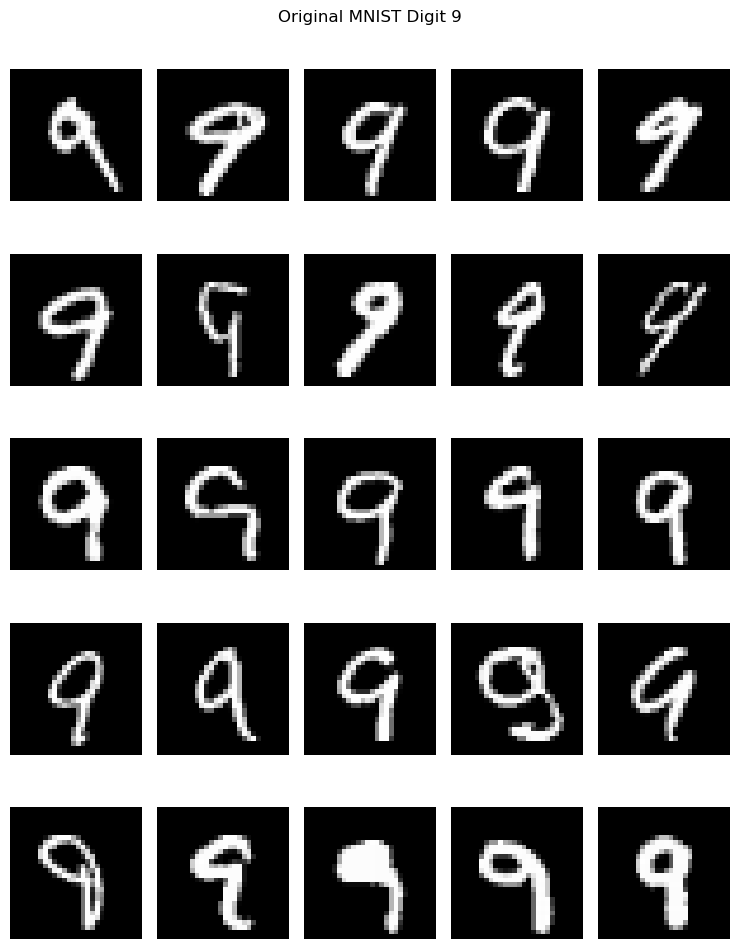

In [22]:
# Define the number of rows and columns for the image grid
N_COLS = 5
N_ROWS = 5

# Randomly select a digit label to visualize
digit_label = np.random.randint(1, 10)
selected_images = []

# Select images with the specified digit label from the test dataset
for images, labels in test_dataloader:
    for i, label in enumerate(labels):
        if label == digit_label:
            selected_images.append(images[i])
        if len(selected_images) == N_COLS * N_ROWS:
            break
    if len(selected_images) == N_COLS * N_ROWS:
        break

# Convert the selected images to numpy arrays
numpy_orig_images = [img.detach().cpu().numpy().squeeze() for img in selected_images]

# Display the selected images
show_images(numpy_orig_images, num_rows=N_ROWS, num_cols=N_COLS, title=f"Original MNIST Digit {digit_label}")

### Latent Space Visualization

  0%|          | 0/20 [00:00<?, ?it/s]

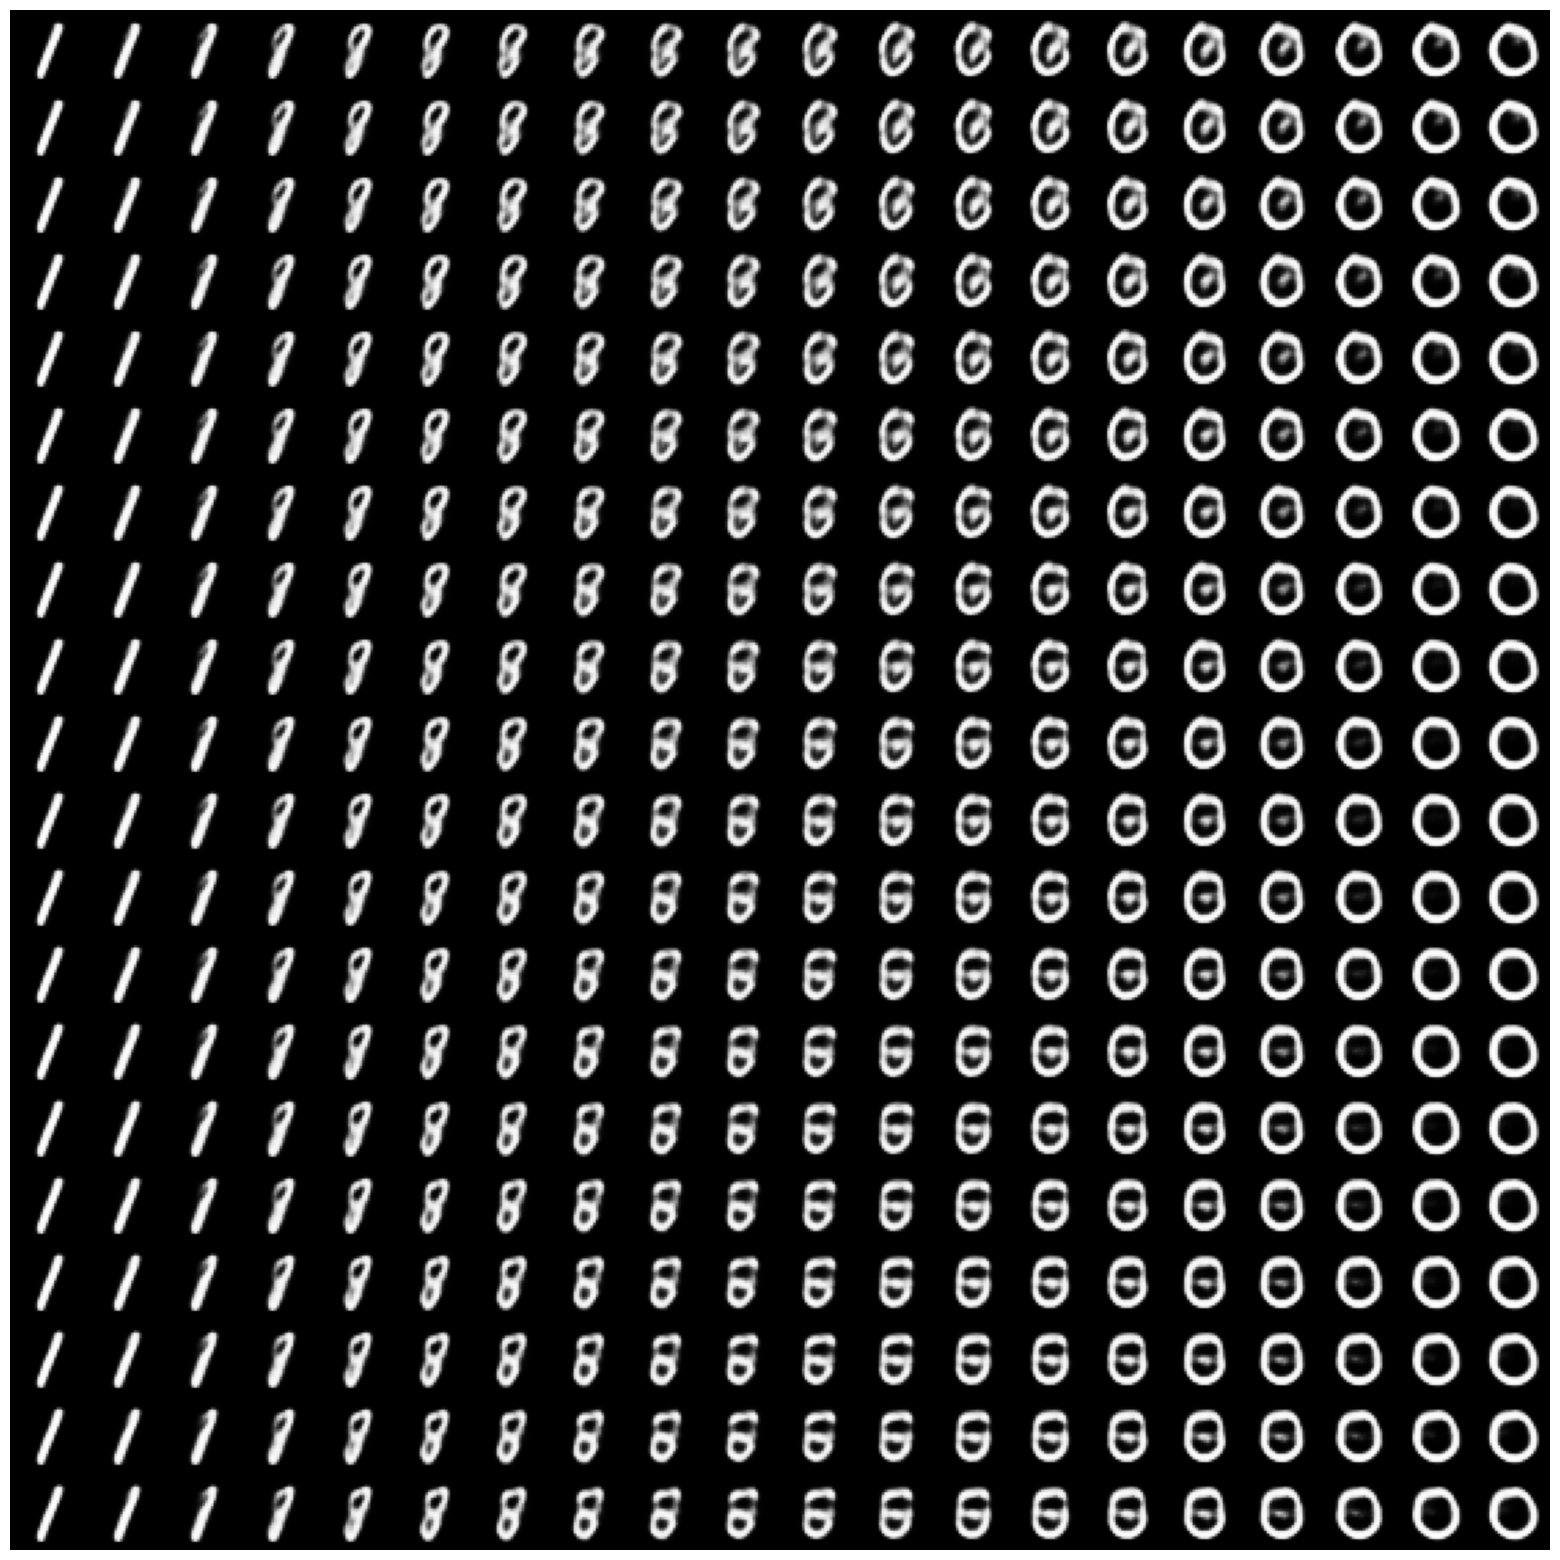

In [23]:
# Define grid size and digit size
n = 20
digit_size = 28

# Create grid for the latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)
figure = np.zeros((digit_size * n, digit_size * n))

# Randomly select two dimensions of the latent space to vary
varying_dims = np.random.choice(LATENT_DIM, 2, replace=False)

# Generate and visualize digits by varying the selected dimensions in the latent space
for i, yi in tqdm(enumerate(grid_x), total=len(grid_x), leave=False):
    for j, xi in enumerate(grid_y):
        z_sample = np.zeros(LATENT_DIM)
        z_sample[varying_dims[0]] = xi
        z_sample[varying_dims[1]] = yi
        z_sample = torch.tensor(z_sample).float().to(device)
        with torch.no_grad():
            generated_digit = model.decode(z_sample).cpu().numpy().reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = generated_digit

# Display the generated digits grid
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## Data Analysis

### Data Preparation

In [24]:
# Initialize lists to store data for analysis
all_mu = []
all_labels = []
all_images = []
image_data = []

# Encode data and collect relevant information
for data, labels in tqdm(test_dataloader, leave=False):
    data = data.to(device)
    mu, _ = model.encode(data)
    all_mu.append(mu.detach().cpu().numpy())
    all_labels.append(labels.numpy())
    for image in data:
        image_2d = image.squeeze(0).cpu().numpy()
        all_images.append(image_2d)
    
    # Reconstruct images and calculate loss
    original, reconstructed, loss = reconstruct_images_and_loss(model, data)
    for i in range(data.size(0)):
        image_data.append({
            'original': original[i].detach().cpu().numpy(),
            'reconstructed': reconstructed[i].detach().cpu().numpy(),
            'loss': loss[i].item(),
            'label': labels[i].item()
        })

# Concatenate all collected data
all_mu = np.concatenate(all_mu, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

  0%|          | 0/313 [00:00<?, ?it/s]

### HDBSCAN Clustering

In [25]:
# Import and apply HDBSCAN clustering
from cuml.cluster import HDBSCAN
clusterer = HDBSCAN(min_cluster_size=5, min_samples=5)
hdbscan_labels = clusterer.fit_predict(all_mu)

### DBSCAN Clustering

In [26]:
# Import and apply DBSCAN clustering
from cuml.cluster import DBSCAN
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(all_mu)

### Latent Mappings

In [27]:
# Create a dictionary to map digits to their latent vectors
latent_mappings = {i: [] for i in range(10)}
for mu, label in zip(all_mu, all_labels):
    latent_mappings[label].append(mu)

# Convert list to numpy arrays
for digit in tqdm(latent_mappings, leave=False):
    latent_mappings[digit] = np.array(latent_mappings[digit])

  0%|          | 0/10 [00:00<?, ?it/s]

### Dimensionality Reduction


#### PCA

In [28]:
# Import and apply PCA
from cuml.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
mu_pca = pca.fit_transform(all_mu)

#### t-SNE

In [29]:
# Import and apply t-SNE
from cuml.manifold import TSNE
tsne = TSNE(n_components=2, angle=0.01, perplexity=10, n_iter=1000, method='fft', random_state=42)
mu_tsne = tsne.fit_transform(all_mu)

/home/sd205521/anaconda3/envs/rapids-23.12/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


#### UMAP

In [30]:
# Import and apply UMAP
from cuml.manifold import UMAP
umap_model = UMAP(n_components=2, random_state=42)
mu_umap = umap_model.fit_transform(all_mu)

### Visualization of Latent Space

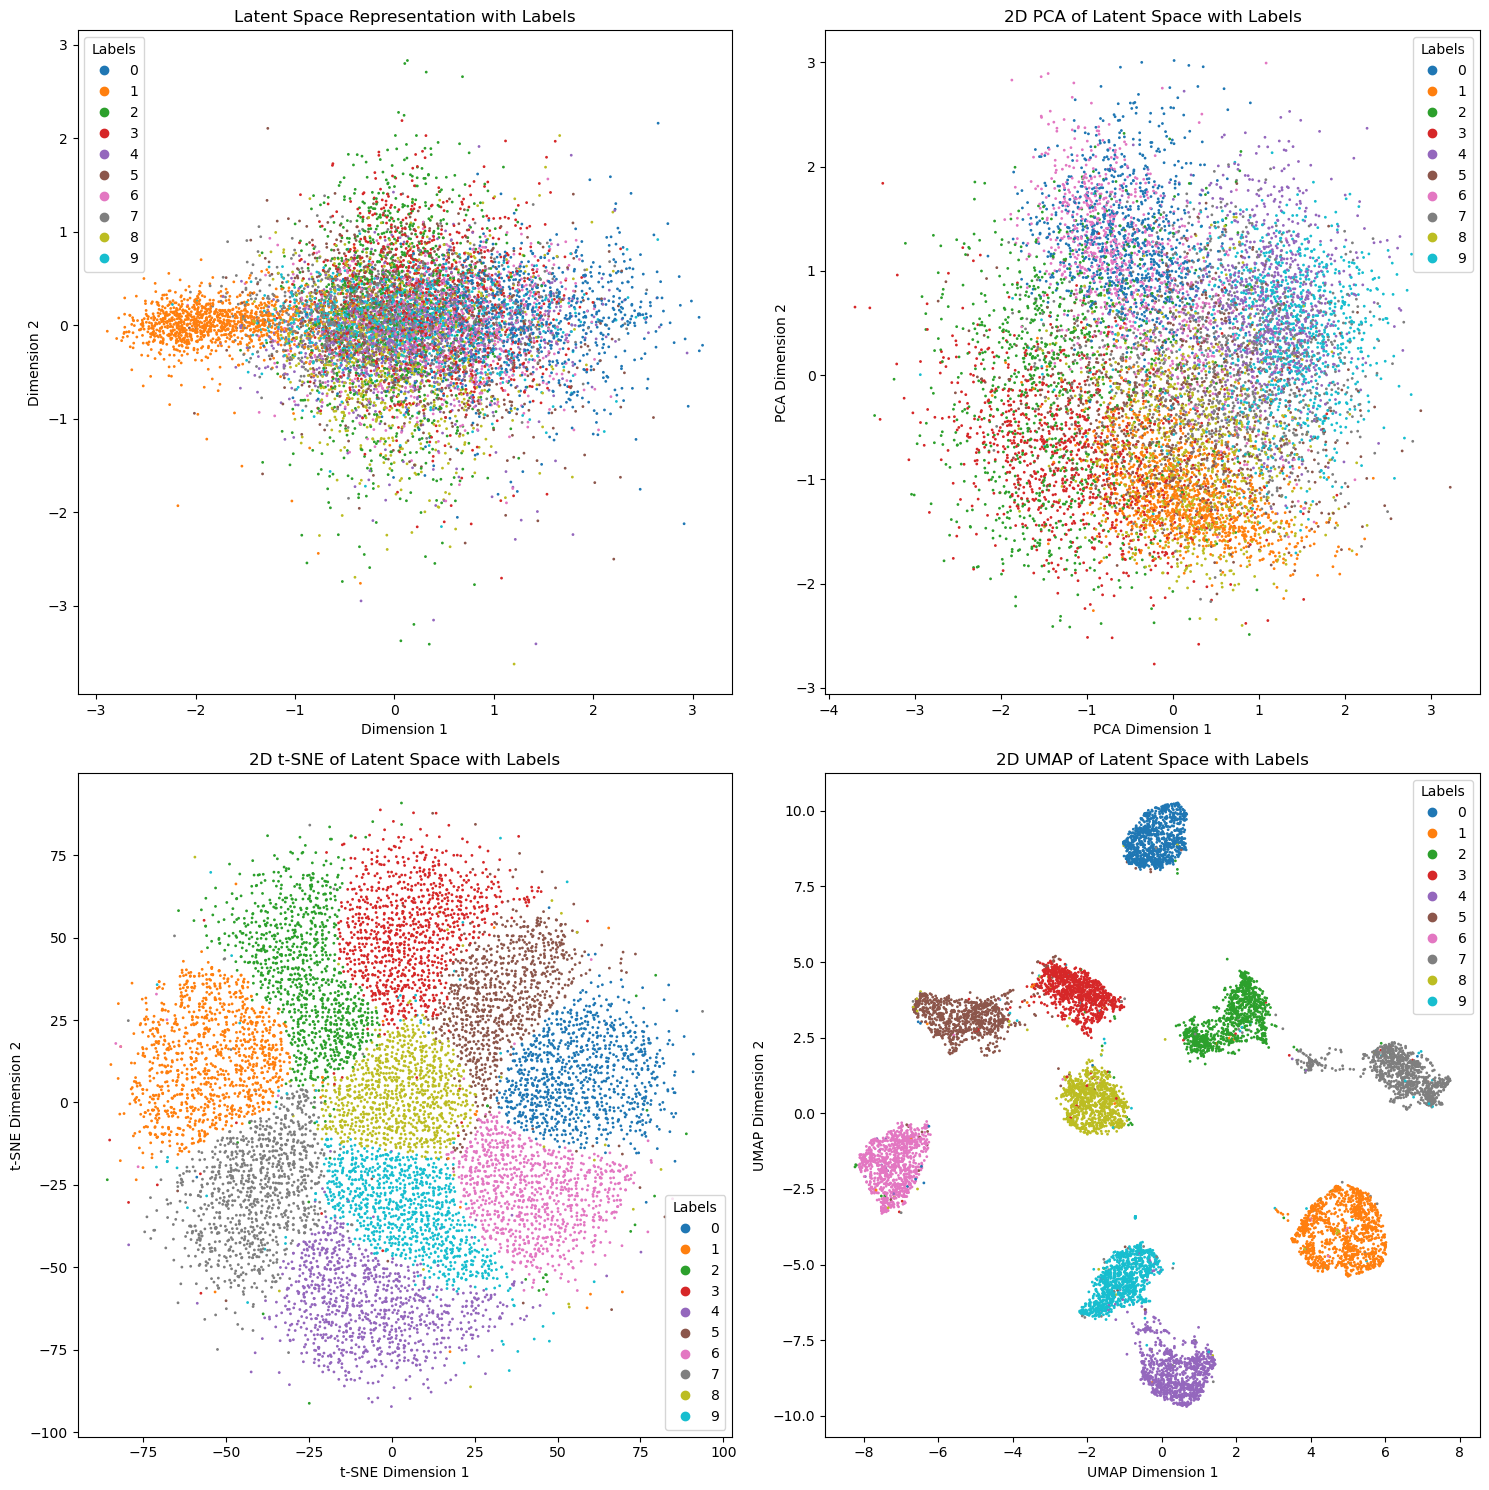

In [31]:
# Plot latent space and dimensionality reduction results
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Latent space representation
scatter = axs[0, 0].scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10', s=1)
axs[0, 0].set_title('Latent Space Representation with Labels')
axs[0, 0].set_xlabel('Dimension 1')
axs[0, 0].set_ylabel('Dimension 2')
axs[0, 0].legend(*scatter.legend_elements(), title="Labels")

# PCA representation
scatter = axs[0, 1].scatter(mu_pca[:, 0], mu_pca[:, 1], c=all_labels, cmap='tab10', s=1)
axs[0, 1].set_title('2D PCA of Latent Space with Labels')
axs[0, 1].set_xlabel('PCA Dimension 1')
axs[0, 1].set_ylabel('PCA Dimension 2')
axs[0, 1].legend(*scatter.legend_elements(), title="Labels")

# t-SNE representation
scatter = axs[1, 0].scatter(mu_tsne[:, 0], mu_tsne[:, 1], c=all_labels, cmap='tab10', s=1)
axs[1, 0].set_title('2D t-SNE of Latent Space with Labels')
axs[1, 0].set_xlabel('t-SNE Dimension 1')
axs[1, 0].set_ylabel('t-SNE Dimension 2')
axs[1, 0].legend(*scatter.legend_elements(), title="Labels")

# UMAP representation
scatter = axs[1, 1].scatter(mu_umap[:, 0], mu_umap[:, 1], c=all_labels, cmap='tab10', s=1)
axs[1, 1].set_title('2D UMAP of Latent Space with Labels')
axs[1, 1].set_xlabel('UMAP Dimension 1')
axs[1, 1].set_ylabel('UMAP Dimension 2')
axs[1, 1].legend(*scatter.legend_elements(), title="Labels")

plt.tight_layout()
plt.show()

### DBSCAN on UMAP-Reduced Data

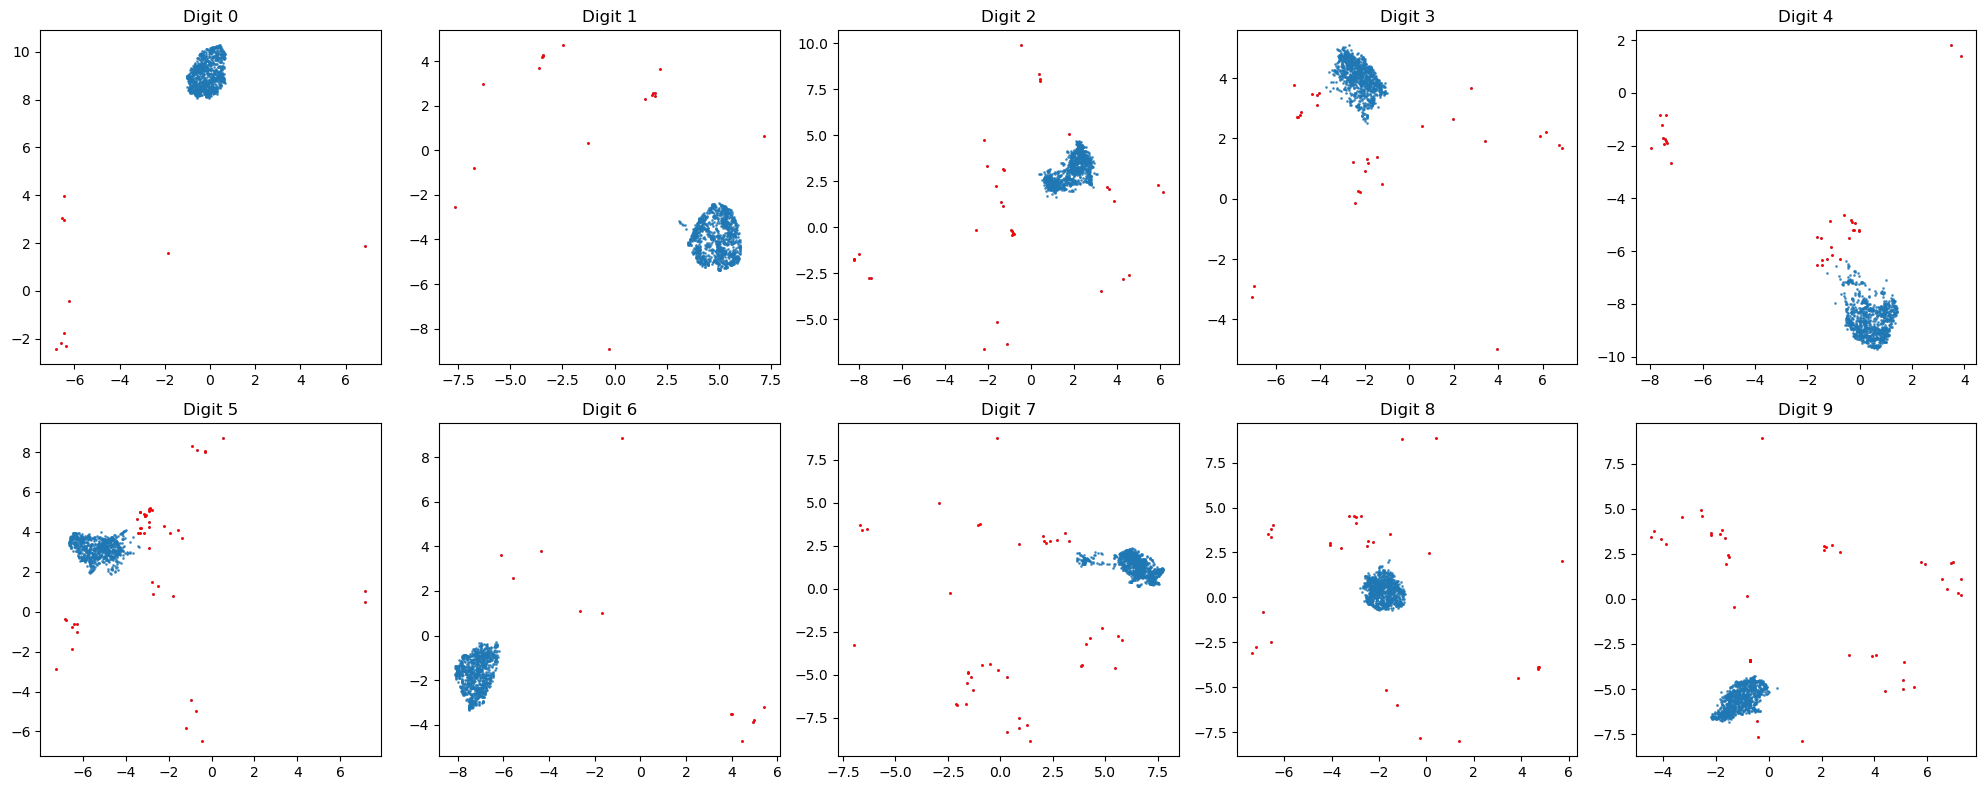

In [32]:
# Apply DBSCAN clustering on UMAP-reduced data and visualize outliers
unique_labels = np.unique(all_labels)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, label in enumerate(unique_labels):
    row = i // 5
    col = i % 5
    filtered_mu_umap = mu_umap[all_labels == label]
    dbscan = DBSCAN(eps=0.5, min_samples=30)
    dbscan.fit(filtered_mu_umap)
    outliers = filtered_mu_umap[dbscan.labels_ == -1]
    ax = axs[row, col]
    ax.scatter(filtered_mu_umap[:, 0], filtered_mu_umap[:, 1], s=1, alpha=0.7)
    ax.scatter(outliers[:, 0], outliers[:, 1], color='red', s=1)
    ax.set_title(f"Digit {label}")

plt.tight_layout()
plt.show()

### Clustering Analysis

#### Cluster Centroids Calculation

In [33]:
# Calculate centroids of clusters using DBSCAN for each label
clusters_centroids = defaultdict(list)
for label in np.unique(all_labels):
    filtered_indices = np.where(all_labels == label)[0]
    filtered_mu_umap = mu_umap[filtered_indices]
    dbscan = DBSCAN(eps=0.5, min_samples=30)
    dbscan.fit(filtered_mu_umap)
    for cluster_id in np.unique(dbscan.labels_):
        if cluster_id != -1:  # Exclude noise points
            cluster_points = filtered_mu_umap[dbscan.labels_ == cluster_id]
            centroid = np.mean(cluster_points, axis=0)
            clusters_centroids[label].append(centroid)

#### Outlier Detection and Nearest Cluster Calculation

In [34]:
# Calculate overall centroids for each label
centroids = {label: np.mean(mu_umap[all_labels == label], axis=0) for label in np.unique(all_labels)}

outliers_info = []
for actual_label in np.unique(all_labels):
    filtered_indices = np.where(all_labels == actual_label)[0]
    filtered_mu_umap = mu_umap[filtered_indices]
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(filtered_mu_umap)
    outlier_indices_filtered = np.where(dbscan.labels_ == -1)[0]  # Noise points as outliers
    outlier_indices_original = filtered_indices[outlier_indices_filtered]
    for idx in outlier_indices_original:
        nearest_cluster = find_nearest_cluster(mu_umap[idx], actual_label, centroids)
        outliers_info.append((idx, actual_label, nearest_cluster))

# Calculate nearest clusters for all points
nearest_clusters = [find_nearest_cluster(point, -1, centroids) for point in mu_umap]
for data_entry, nearest_cluster in zip(image_data, nearest_clusters):
    data_entry['nearest_cluster'] = nearest_cluster

### Outlier Visualization

#### Display Random Outliers


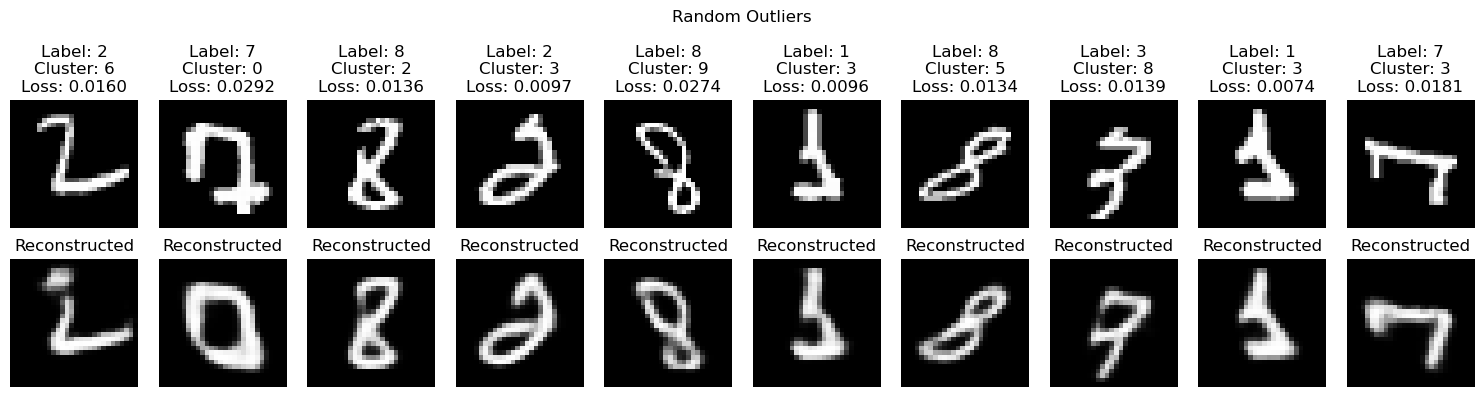

In [35]:
# Select random outliers to visualize
selected_outliers = random.sample(outliers_info, 10)
outlier_indices = [t[0] for t in selected_outliers]
selected_entries = [image_data[index] for index in outlier_indices]

# Display selected outliers with additional info
show_images_with_info(selected_entries, num_images=10, title="Random Outliers")

### UMAP Visualization with Outliers and Labels

#### UMAP Plot with Annotated Outliers

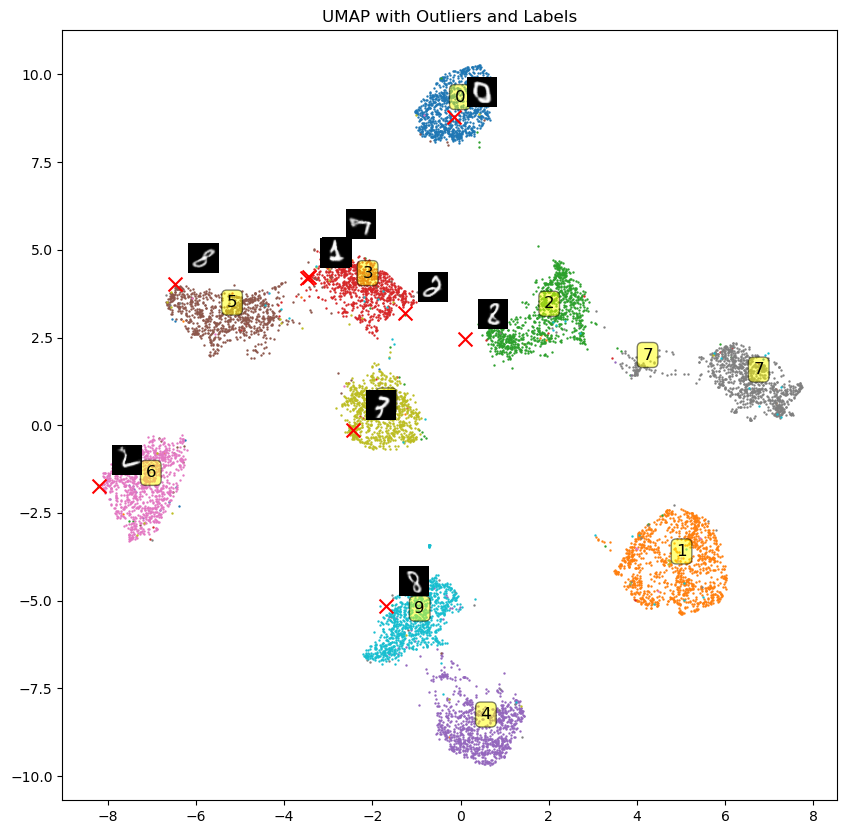

In [36]:
# Plot UMAP with labels and annotate outliers
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each label with different color
for label in unique_labels:
    filtered_mu_umap = mu_umap[all_labels == label]
    ax.scatter(filtered_mu_umap[:, 0], filtered_mu_umap[:, 1], label=f"Label {label}", s=0.5)

# Annotate cluster centroids
for label, centroids in clusters_centroids.items():
    for centroid in centroids:
        ax.annotate(str(label), centroid, textcoords="offset points", xytext=(5, 5), ha='center', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', alpha=0.5))

# Highlight outliers and display their images
for idx, actual_label, nearest_cluster in selected_outliers:
    outlier_point = mu_umap[idx]
    ax.scatter(outlier_point[0], outlier_point[1], color='red', marker='x', s=100)
    processed_image = process_image_through_vae(all_images[idx], model, transform, device)
    inset_size = 0.3
    offset = 0.3
    inset_x = outlier_point[0] + offset
    inset_y = outlier_point[1] + offset
    inset_ax = inset_locator.inset_axes(ax, width=inset_size, height=inset_size, loc='lower left', bbox_to_anchor=(inset_x, inset_y),
                                        bbox_transform=ax.transData, borderpad=0)
    inset_ax.imshow(processed_image, cmap='gray')
    inset_ax.axis('off')

# Set plot title
ax.set_title("UMAP with Outliers and Labels")
plt.show()

## Image Generation

### Generate and Display Sampled Images

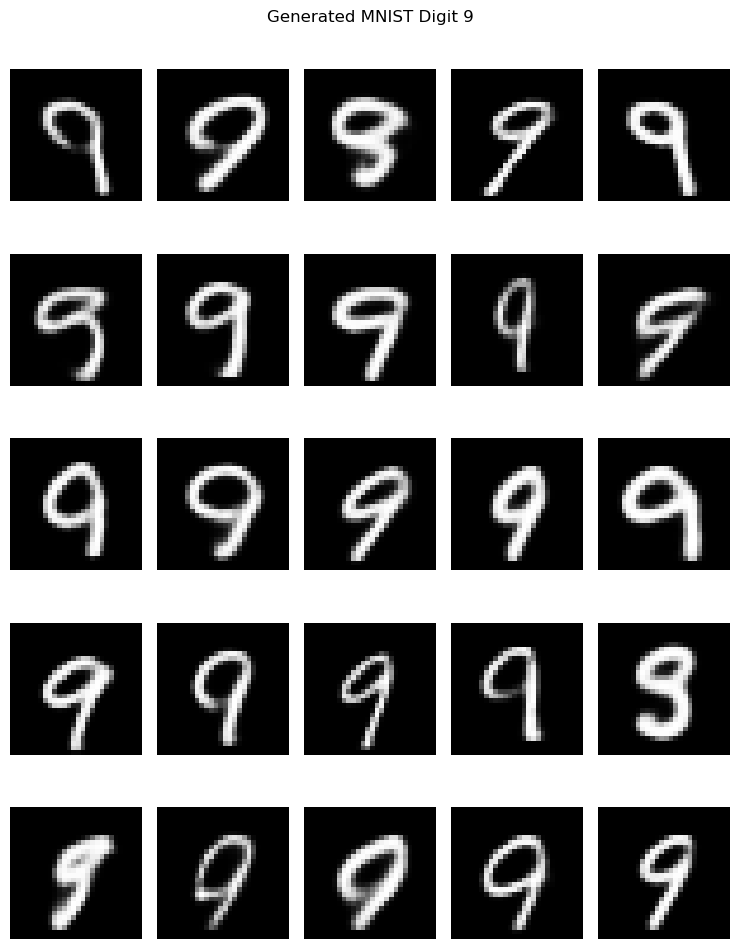

In [37]:
# Sample latent points for the specified digit
sampled_latent_points = sample_digit(latent_mappings, digit_label, num_samples=(N_COLS * N_ROWS), latent_dim=LATENT_DIM)

# Generate images from sampled latent points
generated_images = [model.decode(torch.from_numpy(point).float().to(device)) for point in sampled_latent_points]
numpy_gen_images = [img.squeeze().detach().cpu().numpy() for img in generated_images]

# Display the generated images
show_images(numpy_gen_images, num_rows=N_ROWS, num_cols=N_COLS, title=f"Generated MNIST Digit {digit_label}")

### Error Analysis

#### Top Errors

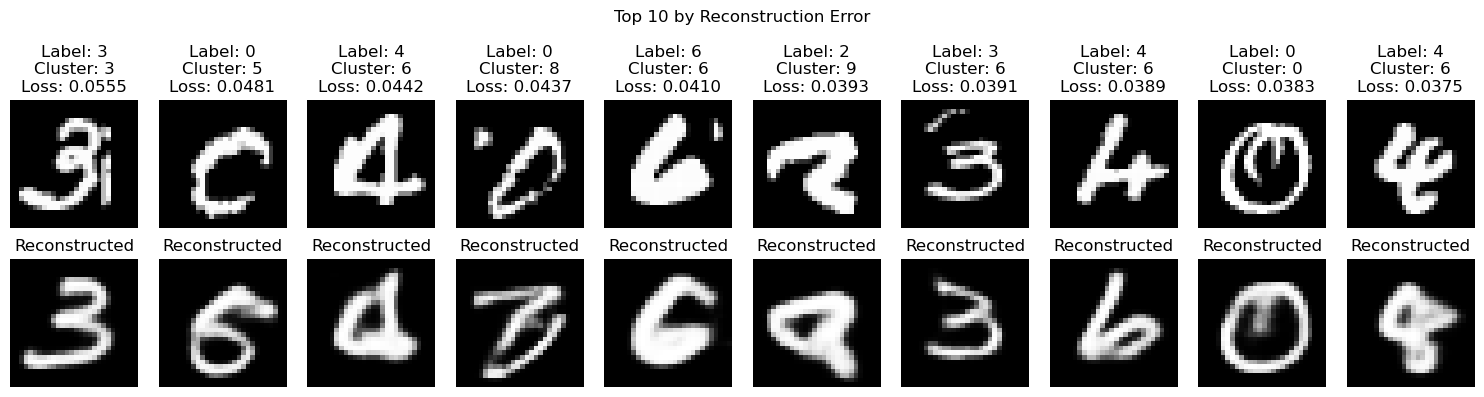

In [38]:
# Select top 10 images with highest reconstruction error
top_images = sorted(image_data, key=lambda x: x['loss'], reverse=True)[:10]

# Display top 10 images by reconstruction error
show_images_with_info(top_images, num_images=10, title="Top 10 by Reconstruction Error")

#### Bottom Errors

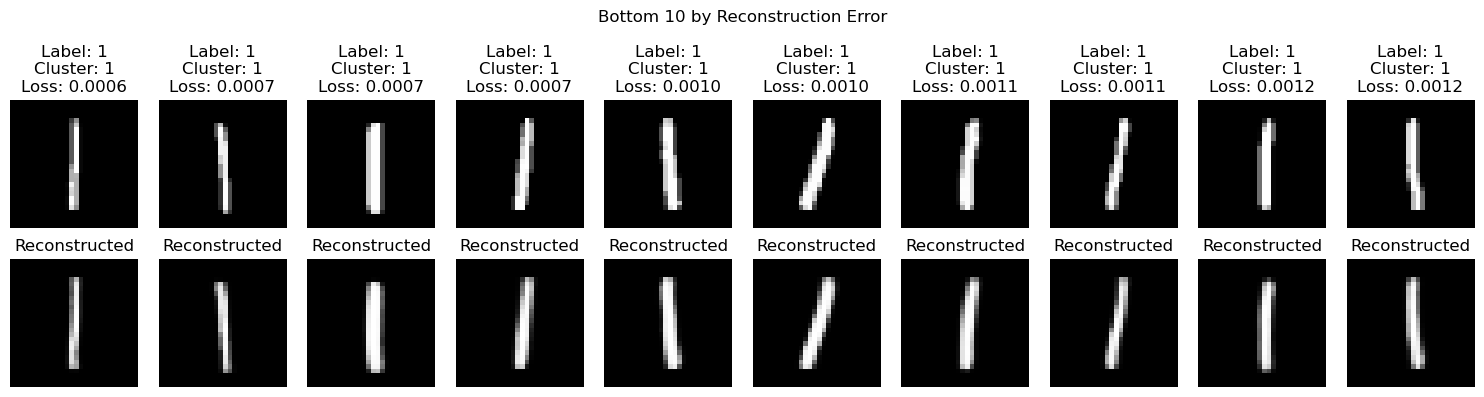

In [39]:
# Select top 10 images with lowest reconstruction error
bottom_images = sorted(image_data, key=lambda x: x['loss'], reverse=False)[:10]

# Display top 10 images by reconstruction error
show_images_with_info(bottom_images, num_images=10, title="Bottom 10 by Reconstruction Error")

#### Random Errors

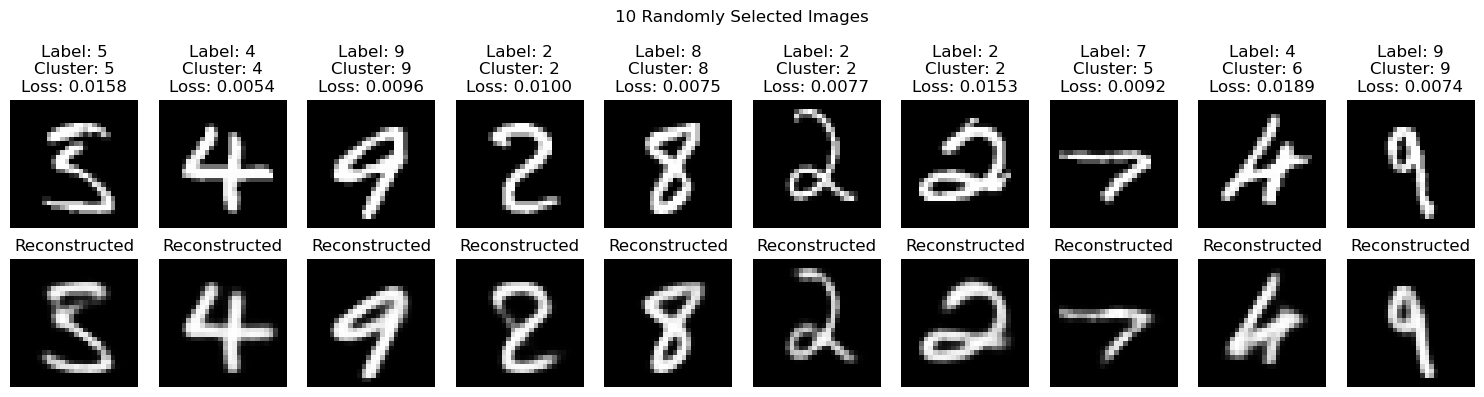

In [40]:
# Randomly select 10 images from the dataset
random_images = random.sample(image_data, 10)

# Display 10 randomly selected images
show_images_with_info(random_images, num_images=10, title="10 Randomly Selected Images")

### Calculate and Display Average Error per Digit

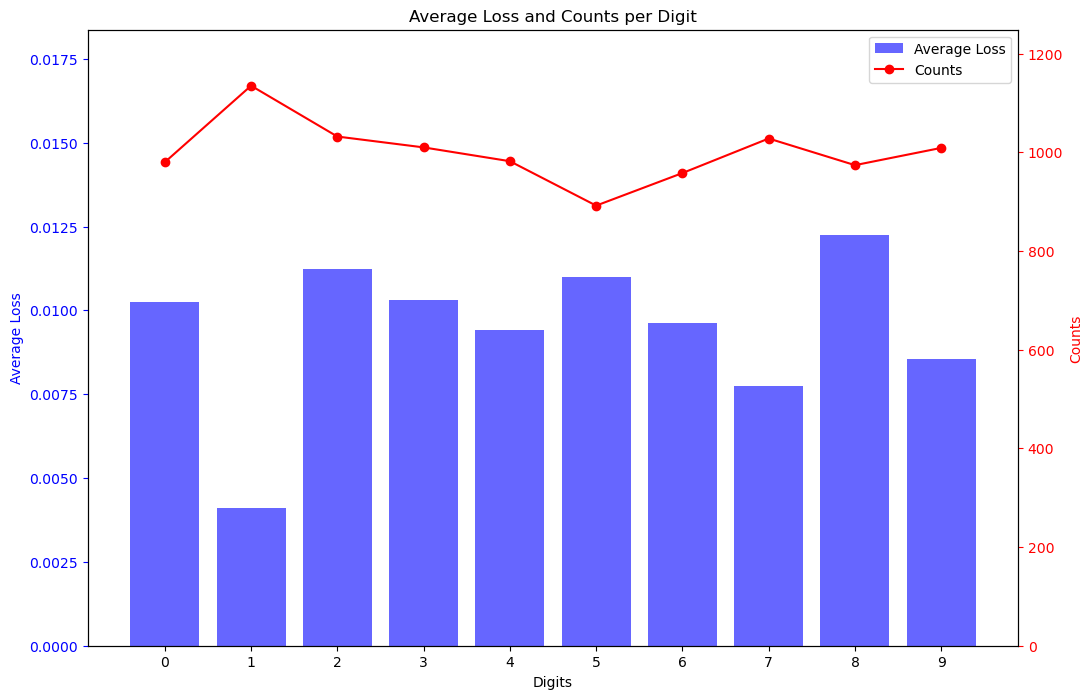

In [41]:
# Calculate total loss and count per digit
losses = defaultdict(int)
counts = defaultdict(int)
for item in image_data:
    label = item['label']
    loss = item['loss']
    losses[label] += loss
    counts[label] += 1

# Calculate average loss per digit
average_losses = {label: losses[label] / counts[label] for label in losses}
labels = list(average_losses.keys())
avg_loss = list(average_losses.values())
count_values = [counts[label] for label in labels]

# Sort the data for plotting
sorted_indices = sorted(range(len(labels)), key=lambda k: labels[k])
sorted_labels = [labels[i] for i in sorted_indices]
sorted_avg_loss = [avg_loss[i] for i in sorted_indices]
sorted_count_values = [count_values[i] for i in sorted_indices]

# Plot average loss and count per digit
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.bar(sorted_labels, sorted_avg_loss, color='b', alpha=0.6, label='Average Loss')
ax1.set_xlabel('Digits')
ax1.set_ylabel('Average Loss', color='b')
ax1.set_ylim(0, max(sorted_avg_loss) * 1.5)
ax1.set_xticks(range(len(sorted_labels)))
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(sorted_labels, sorted_count_values, color='r', marker='o', label='Counts')
ax2.set_ylabel('Counts', color='r')
ax2.set_ylim(0, max(sorted_count_values) * 1.1)
ax2.tick_params('y', colors='r')

# Add legends and title
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
plt.title('Average Loss and Counts per Digit')
plt.show()